Loading feature-engineered dataset...
Loaded features: (57293, 2383), labels: (57293,)
Encoded 14 classes: ['backdoor', 'cryptominer', 'downloader', 'dropper', 'exploit', 'informationstealer', 'p2p-worm', 'pua', 'ransomware', 'rootkit', 'trojan', 'trojan-gamethief', 'virus', 'worm']
Applying SMOTE balancing...
SMOTE balancing complete.
Training LightGBM model...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 4.367567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 558210
[LightGBM] [Info] Number of data points in the train set: 302106, number of used features: 2319
[LightGBM] [Info] Start training from score -2.639057
[LightGBM] [Info] Start training from score -2.639057
[LightGBM] [Info] Start training from score -2.639057
[LightGBM] [Info] Start training from score -2.639057
[LightGBM] [Info] Start training from score -2.639057
[LightGBM] [Info] Start training from score -2.639057
[LightGBM] [Info]

<Figure size 1000x600 with 0 Axes>

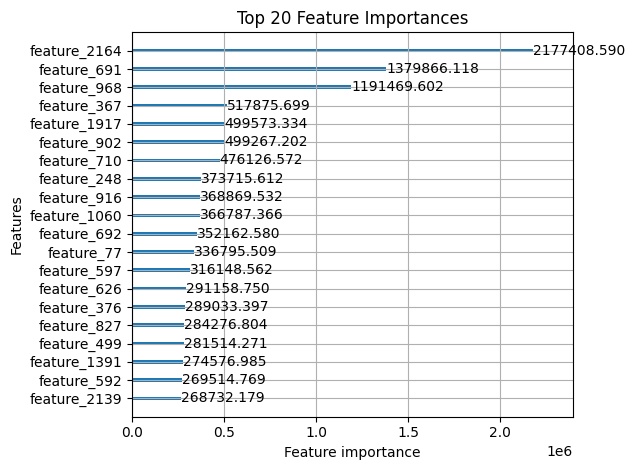

Model and label encoder saved in: models\baseline
Training complete.


In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import joblib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# PATH SETUP
FEATURES_DIR = Path("features")
MODELS_DIR = Path("models/baseline")
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# LOAD DATA
print("Loading feature-engineered dataset...")
X = pd.read_pickle(FEATURES_DIR / "X_features.pkl")
y_raw = pd.read_pickle(FEATURES_DIR / "y_labels.pkl")
print(f"Loaded features: {X.shape}, labels: {y_raw.shape}")

# CLEANING
X = X.loc[:, X.nunique() > 1]
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)
classes = label_encoder.classes_
print(f"Encoded {len(classes)} classes: {list(classes)}")

# TRAIN/TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train, random_state=42
)

# BALANCE CLASSES USING SMOTE (safe version)
print("Applying SMOTE balancing...")
smote = SMOTE(random_state=42, k_neighbors=1)
X_tr, y_tr = smote.fit_resample(X_tr, y_tr)
print("SMOTE balancing complete.")

# MODEL: LIGHTGBM (GPU ENABLED)
print("Training LightGBM model...")
lgbm = lgb.LGBMClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=10,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.1,
    objective='multiclass',
    metric='multi_logloss',
    random_state=42,
    device='gpu'
    devide_id='1'
)

lgbm.fit(X_tr, y_tr,
         eval_set=[(X_val, y_val)],
         eval_metric='multi_logloss',
         verbose=100,
         early_stopping_rounds=50)


lgbm.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    eval_metric='multi_logloss'
)
print("LightGBM training complete.")

# EVALUATION
print("Evaluating model performance...")
y_pred = lgbm.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc*100:.2f}%")

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=classes, zero_division=0))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# FEATURE IMPORTANCE
print("Top 20 Important Features:")
plt.figure(figsize=(10, 6))
lgb.plot_importance(lgbm, max_num_features=20, importance_type='gain', title="Top 20 Feature Importances")
plt.tight_layout()
plt.show()

# SAVE MODEL + ENCODER
joblib.dump(lgbm, MODELS_DIR / "lgbm_final_model.pkl")
joblib.dump(label_encoder, MODELS_DIR / "label_encoder.pkl")

print(f"Model and label encoder saved in: {MODELS_DIR}")
print("Training complete.")
